# Schulich MBAN Analytics Consulting Project
# Client - Interac Corp.
![image info](Schulich_Logo.jpeg)
![image info](Interac-Logo.png)


## Packages

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error
from sqlalchemy import create_engine
import pymysql
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
import shap
import pickle
%matplotlib inline


In [2]:
import sys
sys.path.insert(0, '/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/scr')
from data_transformation_trans import data_transform_histgradientboost, data_transform_XGB
from db_connection import mysql_conn
from model_prediction import prediction

In [3]:
# MySql Local connection
connection = mysql_conn('localhost','ACP','root')
    
print("Reading Training Dataset")
data = pd.read_sql("select * from ACP.interac_dashboard",connection)


# Only year 2019 and 2020 will be considered due to the fact of COVID- 19 and target variable labelling
data1 = data[data['trans_year'].isin([2019,2020])==True]

demo_bank_col = ['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_age', 'user_income',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']

interac_tran_col = ['Liquor/Interac', 'Miscellaneous/Interac', 'grocery/Interac',
       'home/Interac','personal/Interac','restaurant/Interac', 'travel/Interac']

all_tran_col = ['Liquor/Cash', 'Liquor/Interac', 'Liquor/Other', 'Liquor/credit',
       'Miscellaneous/Cash', 'Miscellaneous/Interac', 'Miscellaneous/Other',
       'Miscellaneous/credit', 'grocery/Cash', 'grocery/Interac',
       'grocery/Other', 'grocery/credit', 'home/Cash', 'home/Interac',
       'home/Other', 'home/credit', 'personal/Cash', 'personal/Interac',
       'personal/Other', 'personal/credit', 'restaurant/Cash',
       'restaurant/Interac', 'restaurant/Other', 'restaurant/credit',
       'travel/Cash', 'travel/Interac', 'travel/Other', 'travel/credit']
columns = ['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_age', 'user_income','user_education',
       'user_immigrant_status','user_gender_female',
       'user_gender_male', 'user_gender_other', 'user_region_alberta',
       'user_region_british columbia', 'user_region_east',
       'user_region_man/sask', 'user_region_north', 'user_region_ontario',
       'user_region_quebec', 'user_lifestage_couple no kids',
       'user_lifestage_couple with older kids',
       'user_lifestage_couple with younger kids',
       'user_lifestage_empty nesters', 'user_lifestage_single no kids',
       'user_lifestage_single with kids', 'user_payment_preference_cash',
       'user_payment_preference_credit', 'user_payment_preference_debit',
       'user_payment_preference_mixed','user_banking_package_dkna',
       'user_banking_package_limited', 'user_banking_package_unlimited',
       'user_main_bank_bmo', 'user_main_bank_cibc',
       'user_main_bank_desjardins', 'user_main_bank_other',
       'user_main_bank_pc/simplii', 'user_main_bank_rbc',
       'user_main_bank_scotiabank', 'user_main_bank_tangerine',
       'user_main_bank_td', 'user_main_debit_card_bmo',
       'user_main_debit_card_cibc', 'user_main_debit_card_desjardins',
       'user_main_debit_card_other', 'user_main_debit_card_pc/simplii',
       'user_main_debit_card_rbc', 'user_main_debit_card_scotiabank',
       'user_main_debit_card_tangerine', 'user_main_debit_card_td',
       'user_main_credit_card_amex credit',
       'user_main_credit_card_mastercard credit',
       'user_main_credit_card_no credit card',
       'user_main_credit_card_other credit',
       'user_main_credit_card_visa credit']



Connected to MySQL Server version  8.0.28
You're connected to database:  ('acp',)
Reading Training Dataset


## Model 1A XG BOOST

In [47]:
X,y = data_transform_XGB(data1)
X1= X[columns]
X1 = X1.drop(['user_payment_preference_cash',
       'user_payment_preference_credit', 'user_payment_preference_debit',
       'user_payment_preference_mixed'],axis = 1)

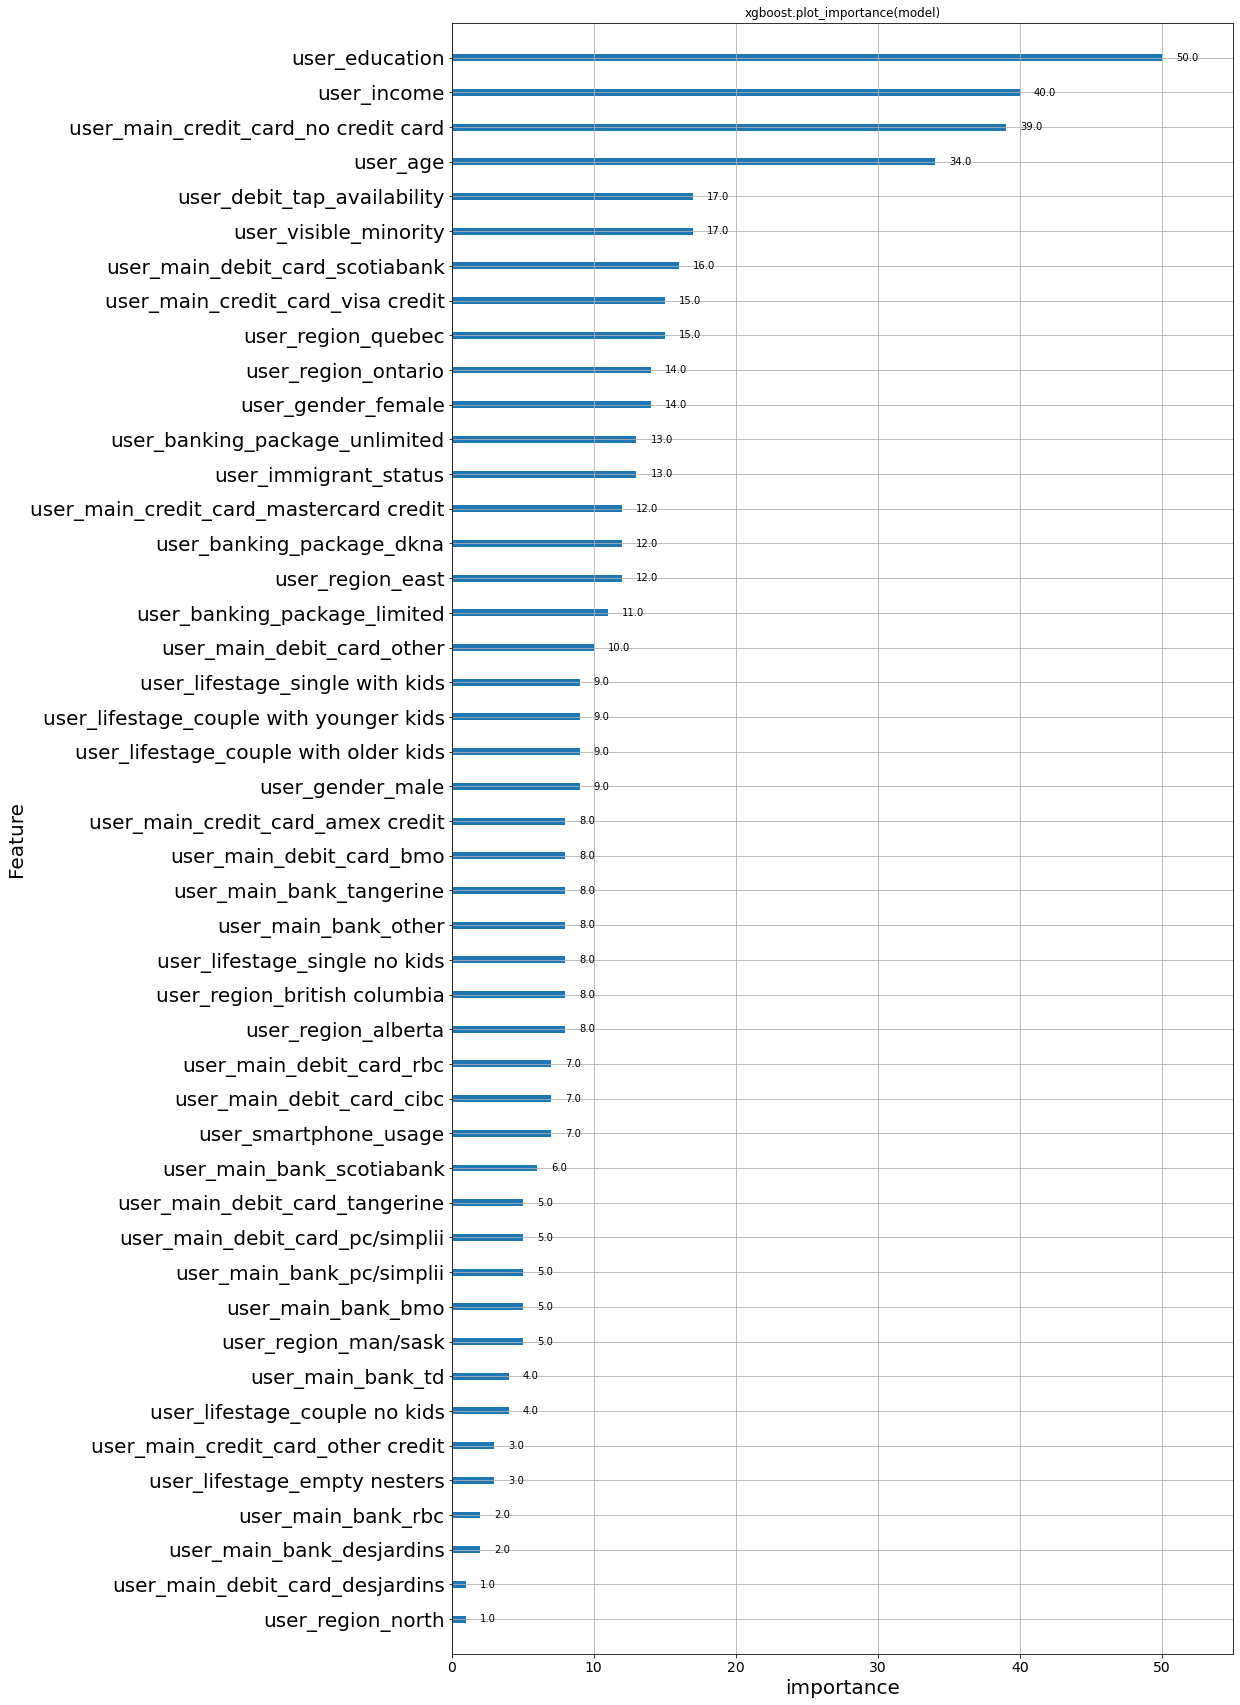

In [39]:
xgb_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/xgb_1A.sav', 'rb'))
best_xgbmodel = xgb_model.best_estimator_
## xgboost model importance
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel)
plt.xlabel('importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

plt.show()

In [49]:
## Bar chart of mean importance

explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X1)
explainer.expected_value
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X1.iloc[0,:])


In [50]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])


In [51]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X1.iloc[0,:])


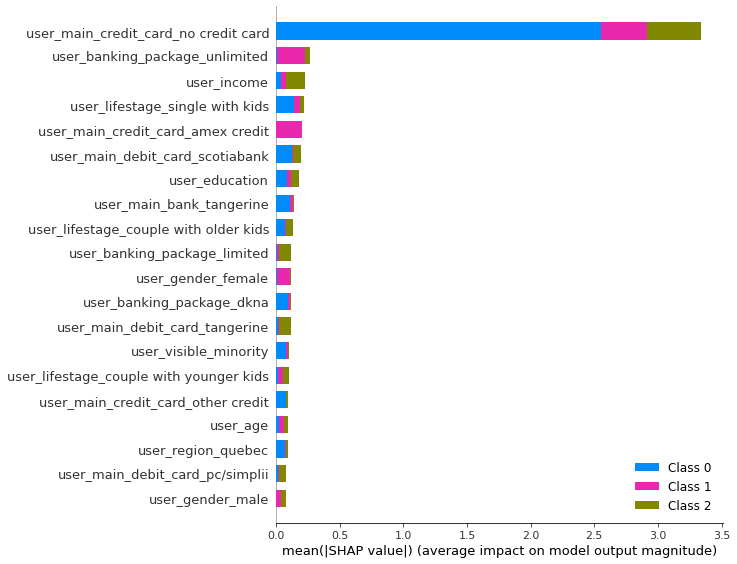

In [52]:
shap.summary_plot(shap_values, X1, plot_type="bar")


### 

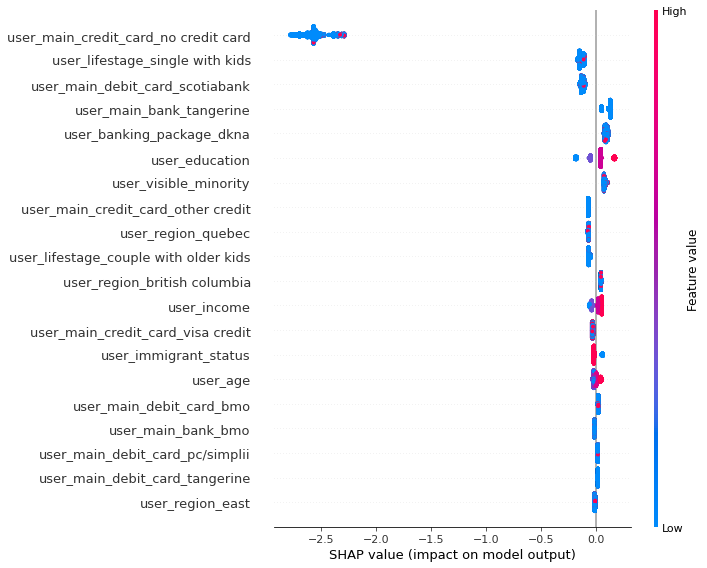

In [53]:

shap.summary_plot(shap_values[0], features=X1.values, feature_names=X1.columns)


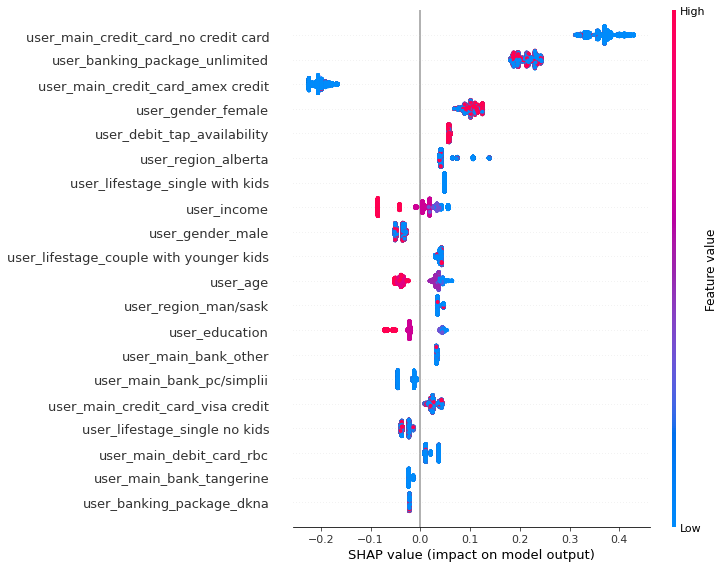

In [54]:

shap.summary_plot(shap_values[1], features=X1.values, feature_names=X1.columns)



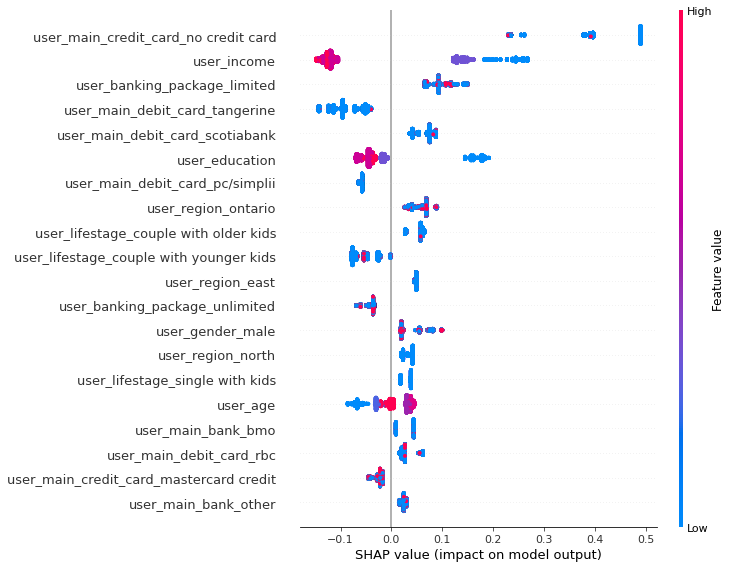

In [55]:
shap.summary_plot(shap_values[2], features=X1.values, feature_names=X1.columns)



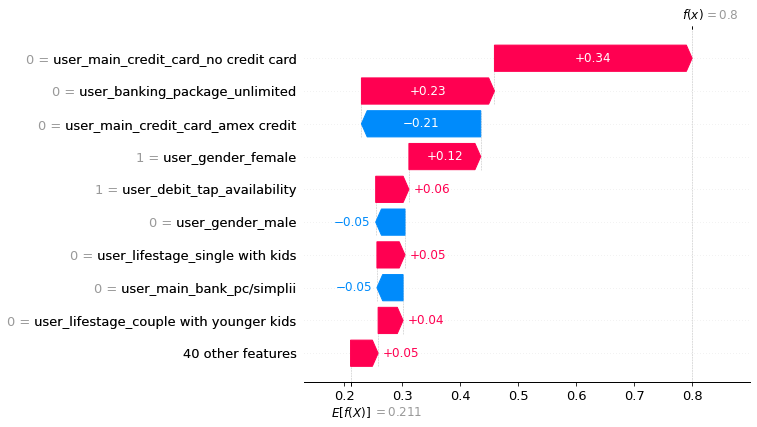

In [56]:
## SHAP Dependence Plots
row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X1.iloc[row],  
                                         feature_names=X1.columns.tolist()))

## Model 1A XG BOOST SELECTOR

In [87]:
X,y = data_transform_XGB(data1)
X1= X[columns]
X1 = X1.drop(['user_payment_preference_cash',
       'user_payment_preference_credit', 'user_payment_preference_debit',
       'user_payment_preference_mixed'],axis = 1)
selector_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/selector_1A.sav', 'rb'))



In [88]:
pd.set_option('display.max_rows', None)
df = pd.DataFrame({"Feature Name": selector_model.get_feature_names_out(), "importance":selector_model.estimator_.feature_importances_}).sort_values(by="importance",ascending=False)
print(df)


                               Feature Name  importance
39     user_main_credit_card_no credit card    0.168264
21           user_banking_package_unlimited    0.112843
7                        user_gender_female    0.039805
19                user_banking_package_dkna    0.038542
20             user_banking_package_limited    0.032829
5                            user_education    0.032446
41        user_main_credit_card_visa credit    0.027754
4                               user_income    0.027679
0                     user_visible_minority    0.026880
35          user_main_debit_card_scotiabank    0.025238
8                          user_gender_male    0.024565
6                     user_immigrant_status    0.023116
38  user_main_credit_card_mastercard credit    0.020079
2               user_debit_tap_availability    0.019974
17            user_lifestage_single no kids    0.019705
3                                  user_age    0.019642
18          user_lifestage_single with kids    0

## Model 1B XG BOOST


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


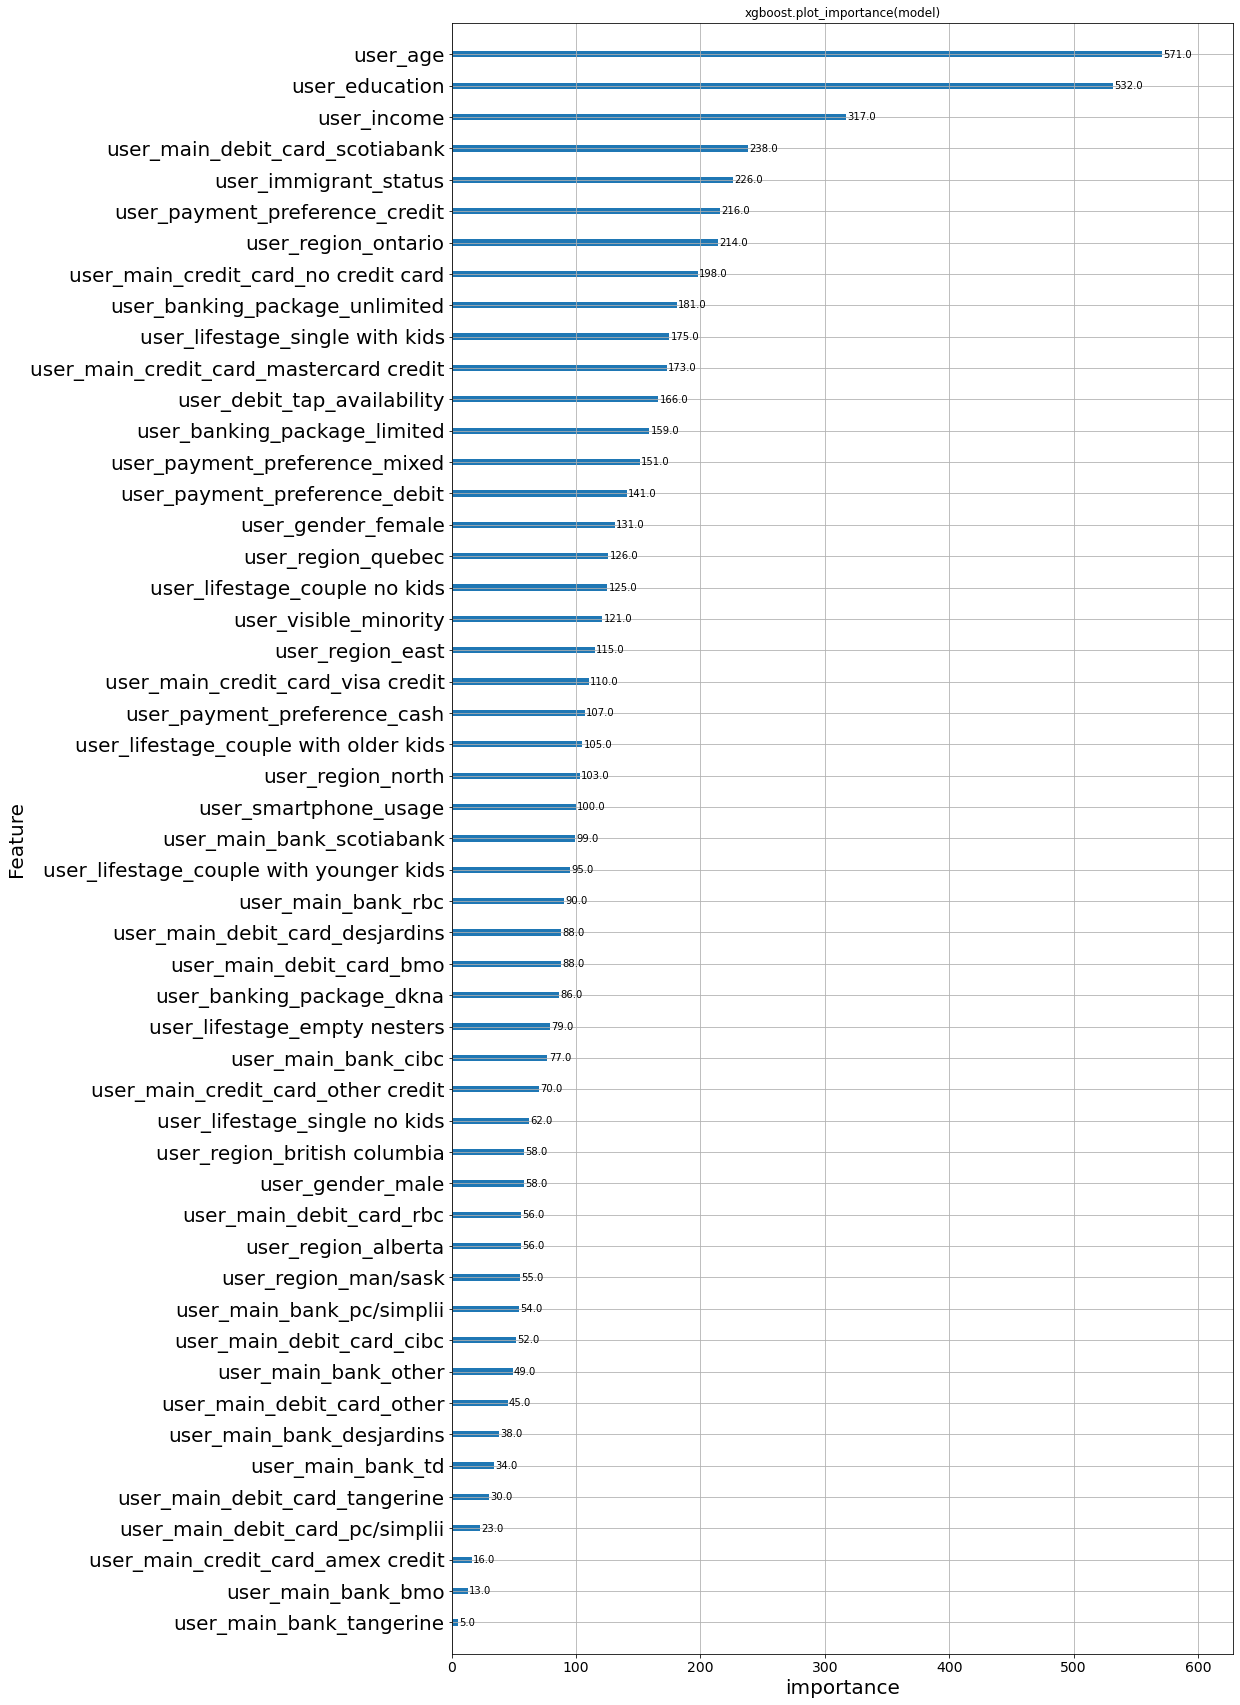

In [57]:
X,y = data_transform_XGB(data1)
X1= X[columns]
xgb_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/xgb_1B.sav', 'rb'))
best_xgbmodel = xgb_model.best_estimator_
## xgboost model importance
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel)
plt.xlabel('importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

plt.show()


In [58]:
## Bar chart of mean importance

explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X1)
explainer.expected_value
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X1.iloc[0,:])



In [59]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])


In [60]:

shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X1.iloc[0,:])


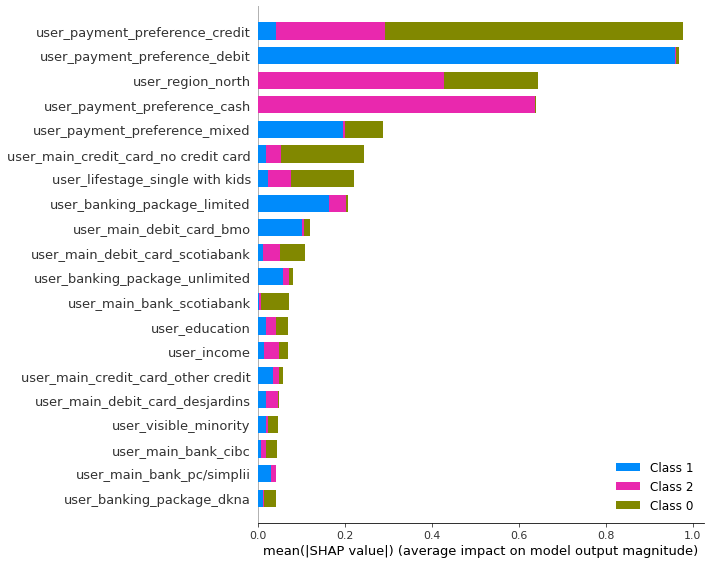

In [61]:

shap.summary_plot(shap_values, X1, plot_type="bar")



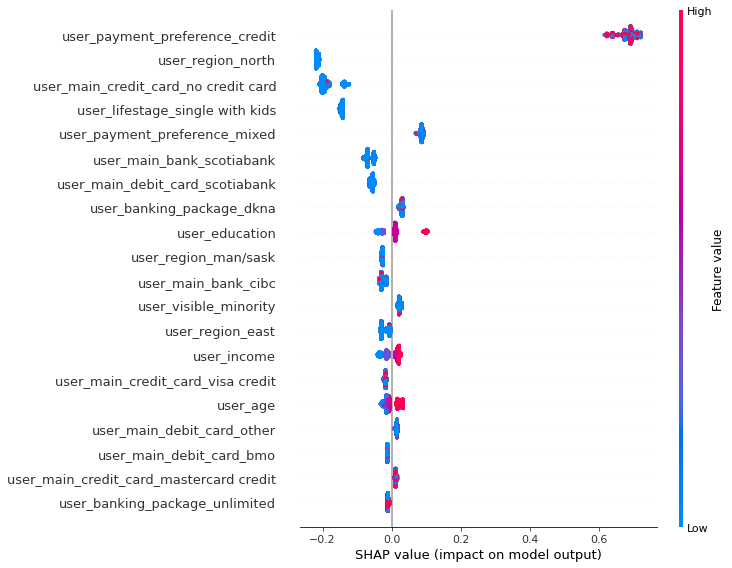

In [62]:

shap.summary_plot(shap_values[0], features=X1.values, feature_names=X1.columns)



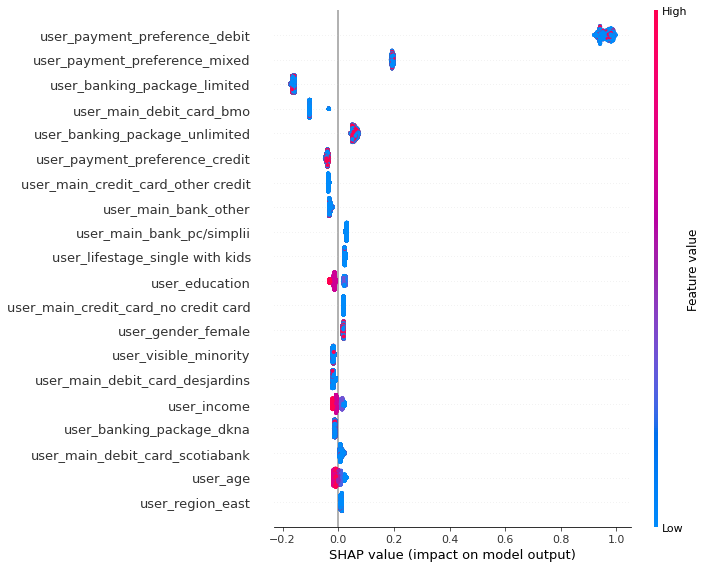

In [63]:

shap.summary_plot(shap_values[1], features=X1.values, feature_names=X1.columns)




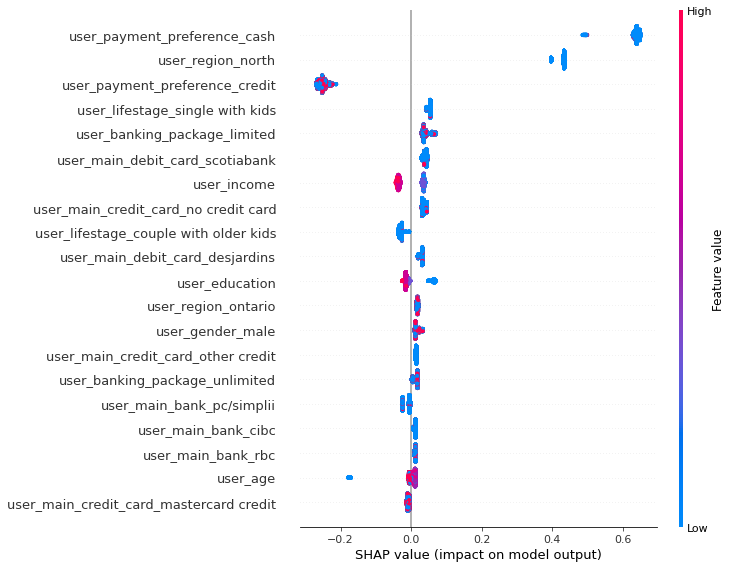

In [64]:
shap.summary_plot(shap_values[2], features=X1.values, feature_names=X1.columns)



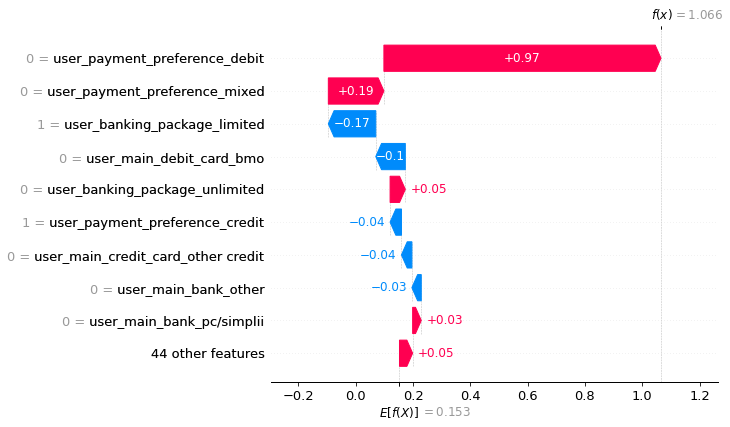

In [65]:

## SHAP Dependence Plots
row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X1.iloc[row],  
                                         feature_names=X1.columns.tolist()))

In [ ]:
## Model 1B XG BOOST

X,y = data_transform_XGB(data1)
X1= X[columns]
xgb_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/xgb_1B.sav', 'rb'))
best_xgbmodel = xgb_model.best_estimator_
## xgboost model importance
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel)
plt.xlabel('importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

plt.show()

## Bar chart of mean importance

explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X1)
explainer.expected_value
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X1.iloc[0,:])


shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])


shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X1.iloc[0,:])


shap.summary_plot(shap_values, X1, plot_type="bar")



shap.summary_plot(shap_values[0], features=X1.values, feature_names=X1.columns)



shap.summary_plot(shap_values[1], features=X1.values, feature_names=X1.columns)



shap.summary_plot(shap_values[2], features=X1.values, feature_names=X1.columns)



## SHAP Dependence Plots
row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X1.iloc[row],  
                                         feature_names=X1.columns.tolist()))

## Model 1B XG BOOST SELECTOR

In [85]:
X,y = data_transform_XGB(data1)
X1= X[columns]
selector_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/selector_1B.sav', 'rb'))

In [86]:
pd.set_option('display.max_rows', None)
df = pd.DataFrame({"Feature Name": selector_model.get_feature_names_out(), "importance":selector_model.estimator_.feature_importances_}).sort_values(by="importance",ascending=False)
print(df)

                               Feature Name  importance
24            user_payment_preference_debit    0.321094
23           user_payment_preference_credit    0.310144
25            user_payment_preference_mixed    0.144063
22             user_payment_preference_cash    0.100844
48     user_main_credit_card_no credit card    0.016859
28           user_banking_package_unlimited    0.010505
27             user_banking_package_limited    0.008685
26                user_banking_package_dkna    0.005777
4                               user_income    0.004373
8                          user_gender_male    0.004363
47  user_main_credit_card_mastercard credit    0.003952
19             user_lifestage_empty nesters    0.003870
2               user_debit_tap_availability    0.003259
7                        user_gender_female    0.003240
0                     user_visible_minority    0.003219
20            user_lifestage_single no kids    0.003214
5                            user_education    0

## Model 2A XG BOOST

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


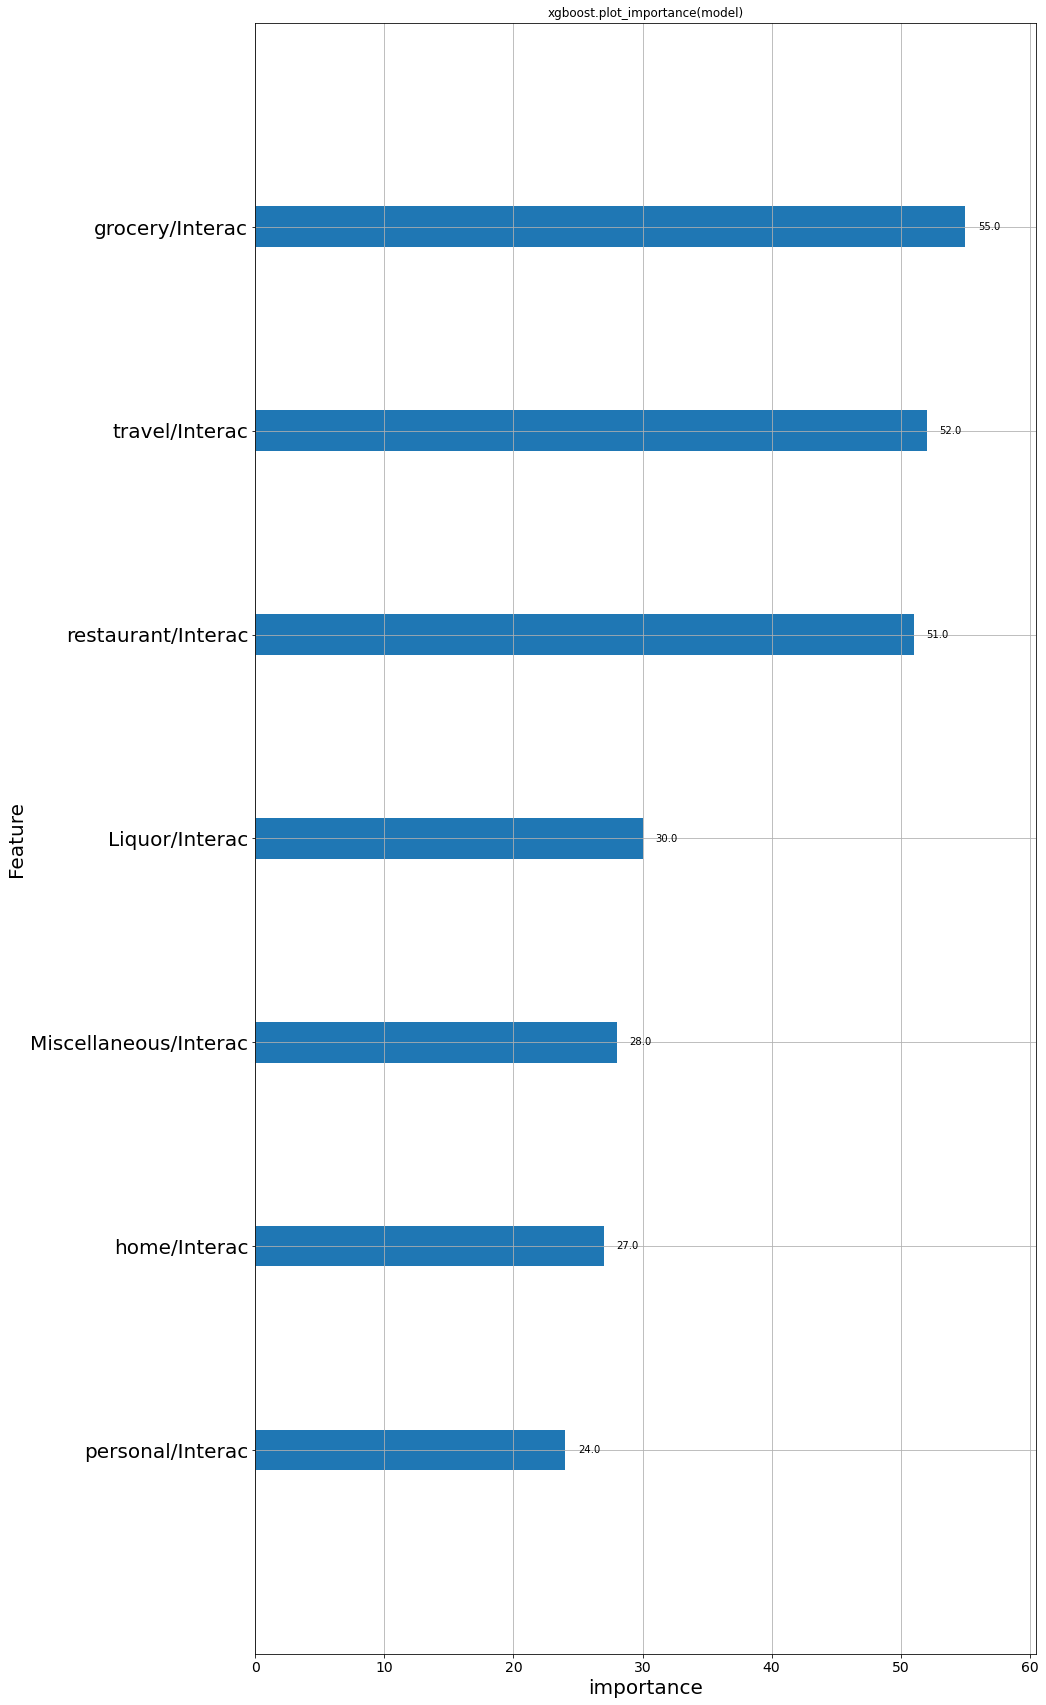

In [89]:
X,y = data_transform_XGB(data1)
X1= X[interac_tran_col]
xgb_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/xgb_2A.sav', 'rb'))
best_xgbmodel = xgb_model.best_estimator_
## xgboost model importance
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel)
plt.xlabel('importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

plt.show()


In [90]:
## Bar chart of mean importance

explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X1)
explainer.expected_value
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X1.iloc[0,:])


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [91]:

shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])



In [92]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X1.iloc[0,:])



Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


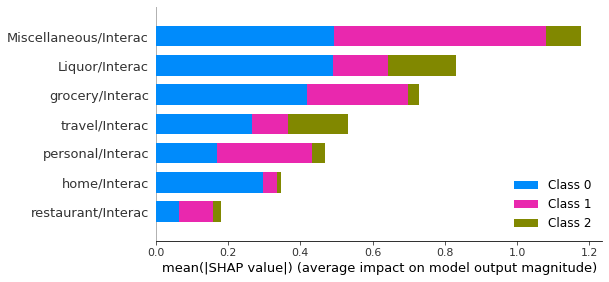

In [93]:
shap.summary_plot(shap_values, X1, plot_type="bar")


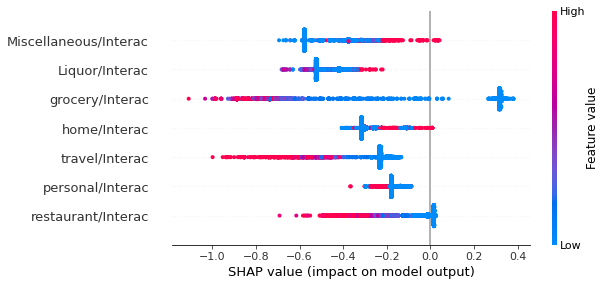

In [94]:
shap.summary_plot(shap_values[0], features=X1.values, feature_names=X1.columns)




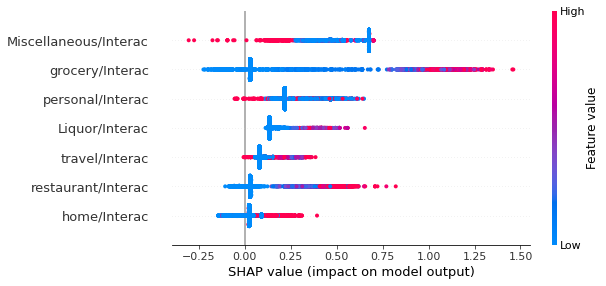

In [95]:
shap.summary_plot(shap_values[1], features=X1.values, feature_names=X1.columns)


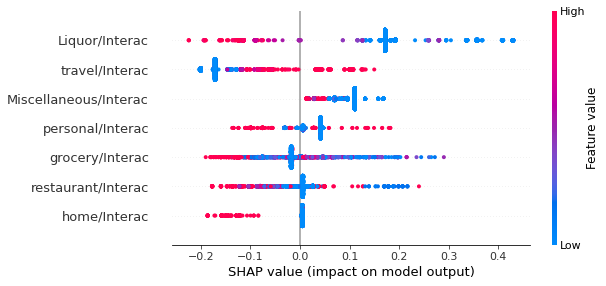

In [96]:

shap.summary_plot(shap_values[2], features=X1.values, feature_names=X1.columns)




Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


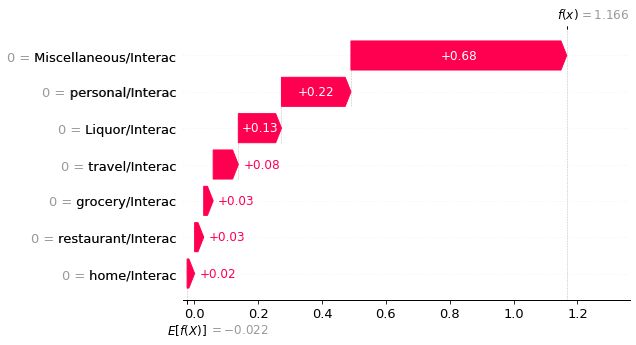

In [97]:
## SHAP Dependence Plots
row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X1.iloc[row],  
                                         feature_names=X1.columns.tolist()))

## Model 2A XG BOOST SELECTOR

In [98]:
X,y = data_transform_XGB(data1)
X1= X[interac_tran_col]
selector_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/selector_2A.sav', 'rb'))
pd.set_option('display.max_rows', None)
df = pd.DataFrame({"Feature Name": selector_model.get_feature_names_out(), "importance":selector_model.estimator_.feature_importances_}).sort_values(by="importance",ascending=False)
print(df)

            Feature Name  importance
2        grocery/Interac    0.694878
5     restaurant/Interac    0.081912
6         travel/Interac    0.063887
0         Liquor/Interac    0.054269
1  Miscellaneous/Interac    0.044240
4       personal/Interac    0.033197
3           home/Interac    0.027618


In [4]:
X,y = data_transform_XGB(data1)
X1= X[interac_tran_col]
knn_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/KNN_2A.sav', 'rb'))
best_knnmodel = knn_model.best_estimator_

In [5]:
X1

,Liquor/Interac,Miscellaneous/Interac,grocery/Interac,home/Interac,personal/Interac,restaurant/Interac,travel/Interac
rid,,,,,,,
00cq6qzr6d88r2g1,0.00,0.00,3.73,0.00,0.0,0.00,0.00
00gu96wutfpymjua,0.00,0.00,0.00,0.00,0.0,0.00,0.00
00h1yh3y46k2t9e1,0.00,0.00,0.00,0.00,0.0,0.00,0.00
00mbm8equ6ce1rq7,0.00,0.00,0.00,0.00,0.0,0.00,0.00
00td84q5gvjh9zy3,0.00,0.00,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...
zz2p4eaqz4np40fr,0.00,692.34,30.34,0.00,0.0,13.39,0.00
zz8cq8tuzvg0fsvr,126.64,0.00,258.74,35.51,0.0,0.00,47.80
zzr23vw3xka94kbx,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [10]:
## Bar chart of mean importance

explainer = shap.KernelExplainer(knn_model.best_estimator_.predict,X1[0:100])


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [11]:
knn_shap_values = explainer.shap_values(X1[0:100])


explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X1)
explainer.expected_value
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X1.iloc[0,:])

  0%|          | 0/100 [00:00<?, ?it/s]X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  1%|          | 1/100 [00:00<00:35,  2.79it/s]X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  2%|▏         | 2/100 [00:00<00:38,  2.57it/s]X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  3%|▎         | 3/100 [00:01<00:38,  2.50it/s]X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  4%|▍         | 4/100 [00:01<00:38,  2.49it/s]X does not have valid feature names, 

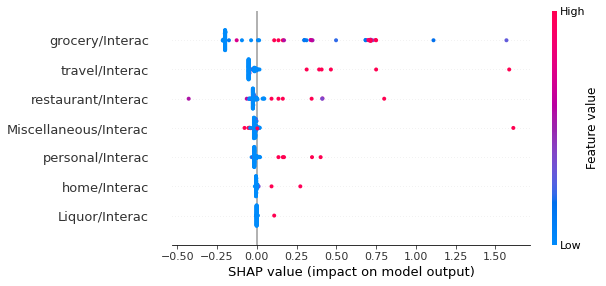

In [12]:
shap.summary_plot(knn_shap_values, X1[0:100])
.expected_value[0]

In [111]:

shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])


In [112]:


shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X1.iloc[0,:])




Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


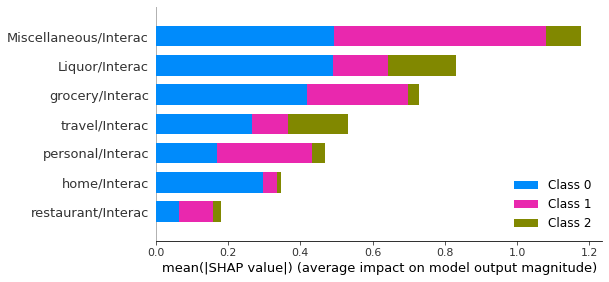

In [113]:
shap.summary_plot(shap_values, X1, plot_type="bar")



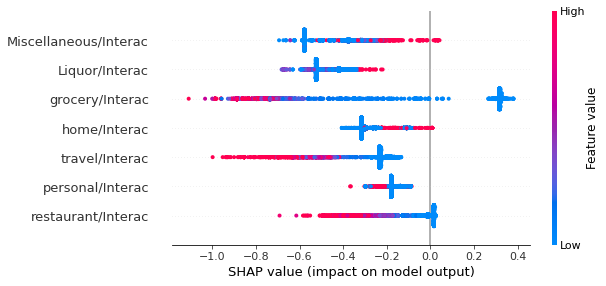

In [114]:
shap.summary_plot(shap_values[0], features=X1.values, feature_names=X1.columns)





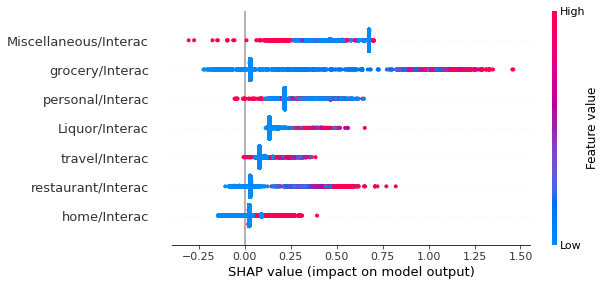

In [115]:
shap.summary_plot(shap_values[1], features=X1.values, feature_names=X1.columns)




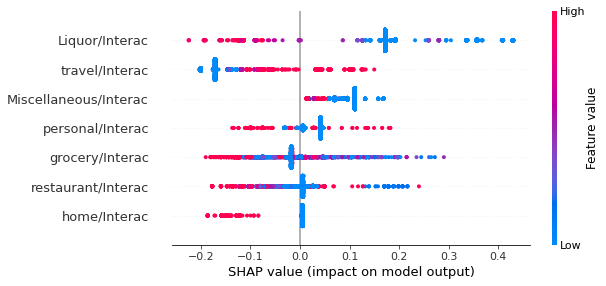

In [116]:
shap.summary_plot(shap_values[2], features=X1.values, feature_names=X1.columns)





Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


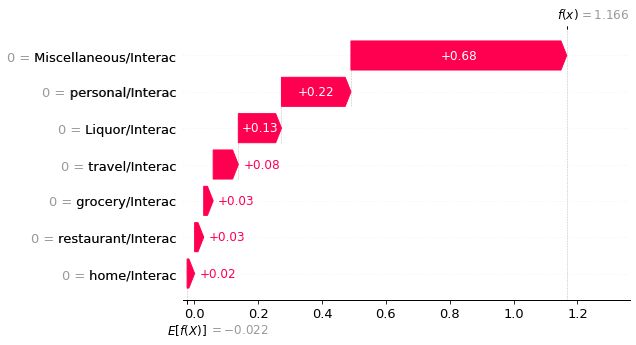

In [117]:
## SHAP Dependence Plots
row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X1.iloc[row],  
                                         feature_names=X1.columns.tolist()))

## Model 2B XG BOOST

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


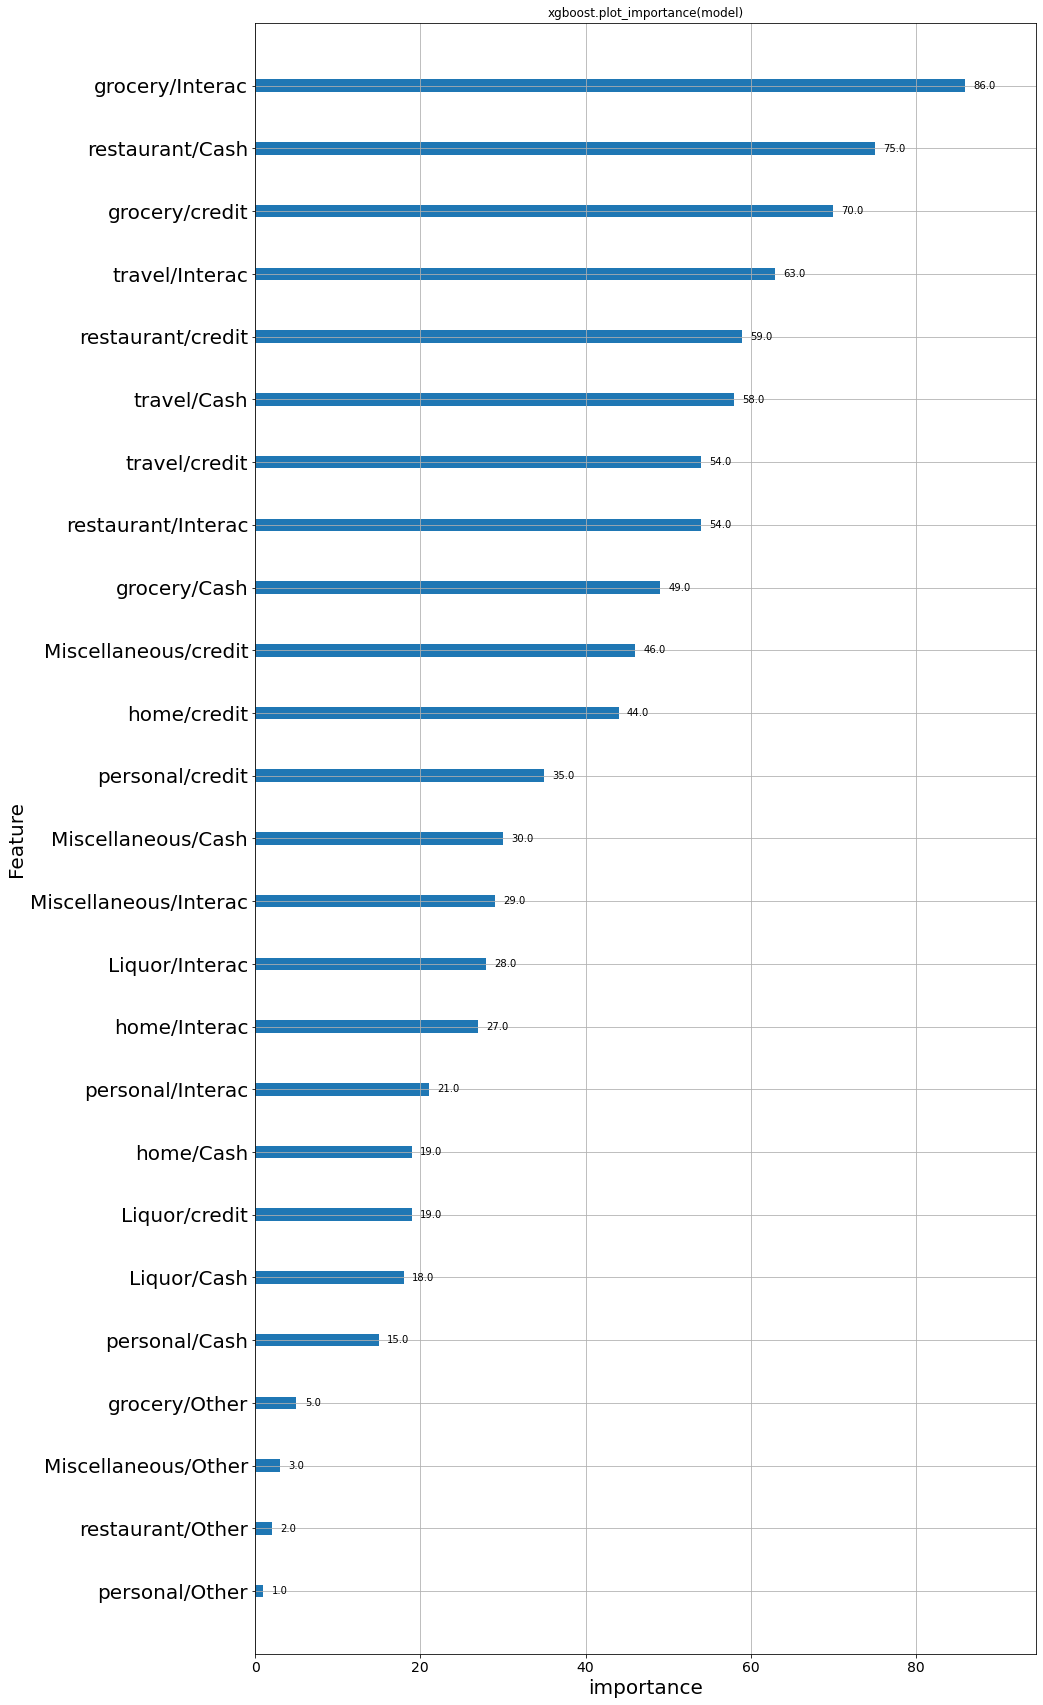

In [99]:
X,y = data_transform_XGB(data1)
X1= X[all_tran_col]
xgb_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/xgb_2B.sav', 'rb'))
best_xgbmodel = xgb_model.best_estimator_
## xgboost model importance
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel)
plt.xlabel('importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

plt.show()



In [100]:
## Bar chart of mean importance

explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X1)
explainer.expected_value
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X1.iloc[0,:])




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [101]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])




In [102]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X1.iloc[0,:])




Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


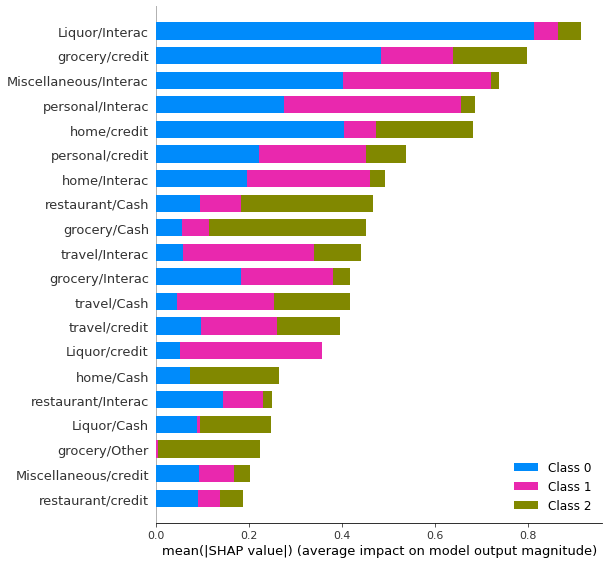

In [103]:
shap.summary_plot(shap_values, X1, plot_type="bar")



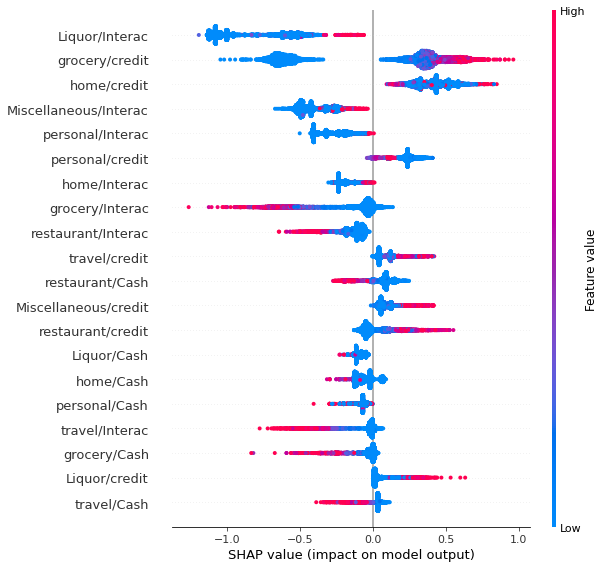

In [104]:
shap.summary_plot(shap_values[0], features=X1.values, feature_names=X1.columns)





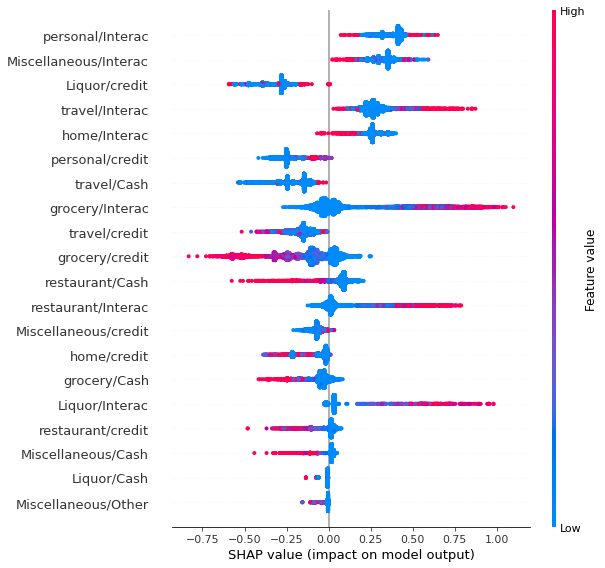

In [105]:
shap.summary_plot(shap_values[1], features=X1.values, feature_names=X1.columns)




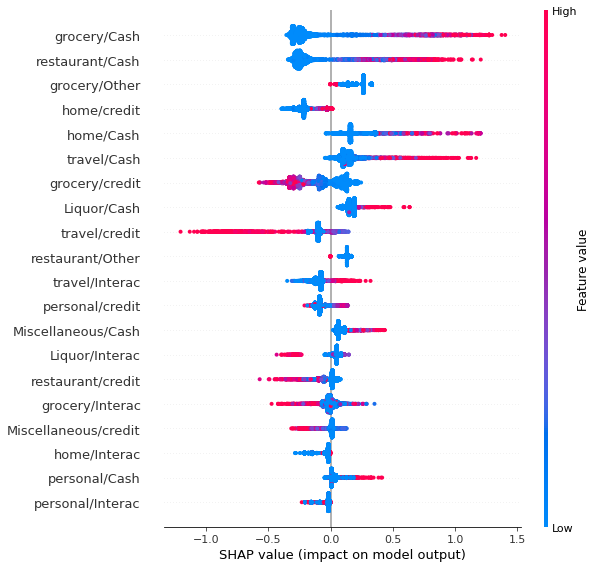

In [106]:
shap.summary_plot(shap_values[2], features=X1.values, feature_names=X1.columns)





Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


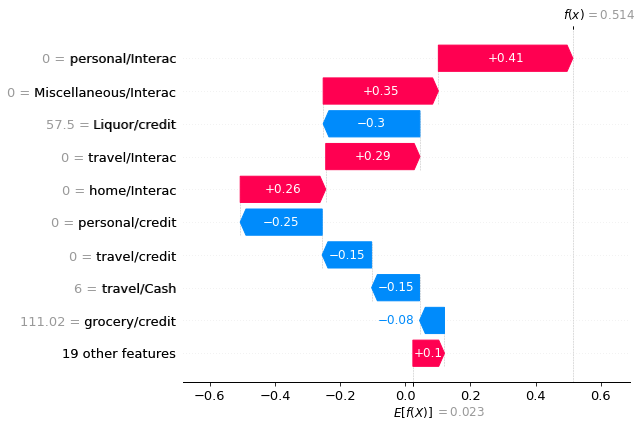

In [107]:
## SHAP Dependence Plots
row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X1.iloc[row],  
                                         feature_names=X1.columns.tolist()))

## Model 2B XG BOOST SELECTOR

In [108]:
X,y = data_transform_XGB(data1)
X1= X[all_tran_col]
selector_model = pickle.load(open('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/InteracSchulichACP/models/selector_2B.sav', 'rb'))
pd.set_option('display.max_rows', None)
df = pd.DataFrame({"Feature Name": selector_model.get_feature_names_out(), "importance":selector_model.estimator_.feature_importances_}).sort_values(by="importance",ascending=False)
print(df)

             Feature Name  importance
4         grocery/Interac    0.261189
5          grocery/credit    0.229288
3            grocery/Cash    0.181088
11     restaurant/Interac    0.045600
14         travel/Interac    0.033185
13            travel/Cash    0.032200
12      restaurant/credit    0.031514
0          Liquor/Interac    0.026185
2   Miscellaneous/Interac    0.025338
15          travel/credit    0.023015
10        restaurant/Cash    0.022237
8             home/credit    0.021876
9        personal/Interac    0.019679
1           Liquor/credit    0.016462
6               home/Cash    0.016217
7            home/Interac    0.014926
